<a href="https://colab.research.google.com/github/whisplnspace/CarDekhoEDA/blob/main/CarDekho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy pathlib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
path = "CAR DETAILS FROM CAR DEKHO.csv"
df = pd.read_csv(path)

In [4]:
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())

Shape: (4340, 8)
Columns: ['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner']
                       name  year  selling_price  km_driven    fuel  \
0             Maruti 800 AC  2007          60000      70000  Petrol   
1  Maruti Wagon R LXI Minor  2007         135000      50000  Petrol   
2      Hyundai Verna 1.6 SX  2012         600000     100000  Diesel   
3    Datsun RediGO T Option  2017         250000      46000  Petrol   
4     Honda Amaze VX i-DTEC  2014         450000     141000  Diesel   

  seller_type transmission         owner  
0  Individual       Manual   First Owner  
1  Individual       Manual   First Owner  
2  Individual       Manual   First Owner  
3  Individual       Manual   First Owner  
4  Individual       Manual  Second Owner  


In [5]:
print("\nMissing values per column:\n", df.isna().sum())
print("\nDuplicate rows:", df.duplicated().sum())
print("\nDescribe (numeric):\n", df[['year','selling_price','km_driven']].describe())


Missing values per column:
 name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
dtype: int64

Duplicate rows: 763

Describe (numeric):
               year  selling_price      km_driven
count  4340.000000   4.340000e+03    4340.000000
mean   2013.090783   5.041273e+05   66215.777419
std       4.215344   5.785487e+05   46644.102194
min    1992.000000   2.000000e+04       1.000000
25%    2011.000000   2.087498e+05   35000.000000
50%    2014.000000   3.500000e+05   60000.000000
75%    2016.000000   6.000000e+05   90000.000000
max    2020.000000   8.900000e+06  806599.000000


In [6]:
df_clean = df.copy()

In [7]:
for col in df_clean.select_dtypes(include="object").columns:
    df_clean[col] = df_clean[col].astype(str).str.strip()

In [8]:
df_clean = df_clean.drop_duplicates(keep="first").reset_index(drop=True)

In [9]:
CURRENT_YEAR = 2025
df_clean["car_age"] = CURRENT_YEAR - df_clean["year"]
df_clean["brand"] = df_clean["name"].str.split().str[0]

In [10]:
q_price_low, q_price_high = df_clean["selling_price"].quantile([0.01, 0.99])
q_km_low, q_km_high = df_clean["km_driven"].quantile([0.01, 0.99])
mask = (
    df_clean["selling_price"].between(q_price_low, q_price_high) &
    df_clean["km_driven"].between(q_km_low, q_km_high)
)
df_filtered = df_clean[mask].reset_index(drop=True)

print("\nCleaned dataset shape:", df_filtered.shape)


Cleaned dataset shape: (3435, 10)


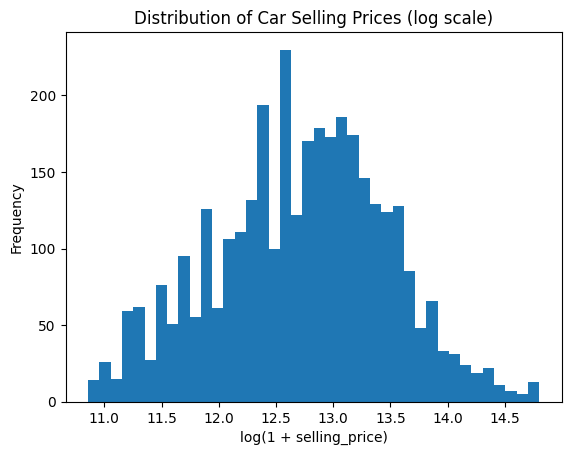

In [14]:
#1 Histogram of log-transformed selling price
plt.figure()
plt.hist(np.log1p(df_filtered["selling_price"]), bins=40)
plt.xlabel("log(1 + selling_price)")
plt.ylabel("Frequency")
plt.title("Distribution of Car Selling Prices (log scale)")
plt.show()

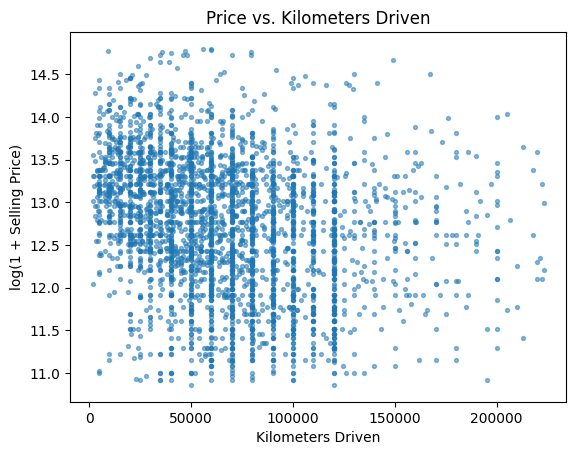

In [15]:
#2 Scatter plot: km_driven vs selling_price
plt.figure()
plt.scatter(df_filtered["km_driven"], np.log1p(df_filtered["selling_price"]),
            s=8, alpha=0.5)
plt.xlabel("Kilometers Driven")
plt.ylabel("log(1 + Selling Price)")
plt.title("Price vs. Kilometers Driven")
plt.show()

/tmp/ipython-input-4255413979.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_fuel, labels=fuel_order, showfliers=False)


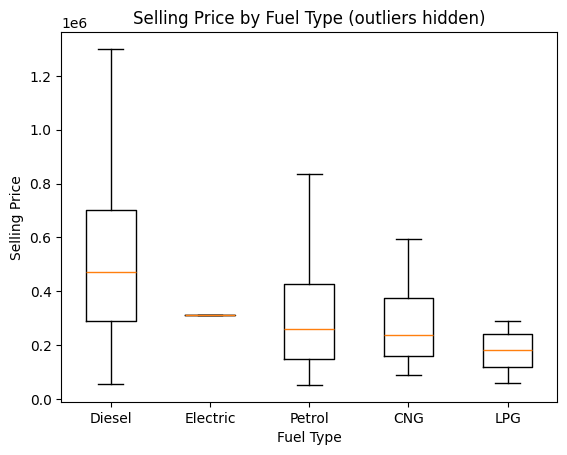

In [18]:
# 3 Boxplot: Selling Price by Fuel Type
fuel_order = (
    df_filtered.groupby("fuel")["selling_price"]
    .median()
    .sort_values(ascending=False)
    .index
    .tolist()
)
data_by_fuel = [df_filtered.loc[df_filtered["fuel"]==f,"selling_price"].values
                for f in fuel_order]

plt.figure()
plt.boxplot(data_by_fuel, labels=fuel_order, showfliers=False)
plt.xlabel("Fuel Type")
plt.ylabel("Selling Price")
plt.title("Selling Price by Fuel Type (outliers hidden)")
plt.show()

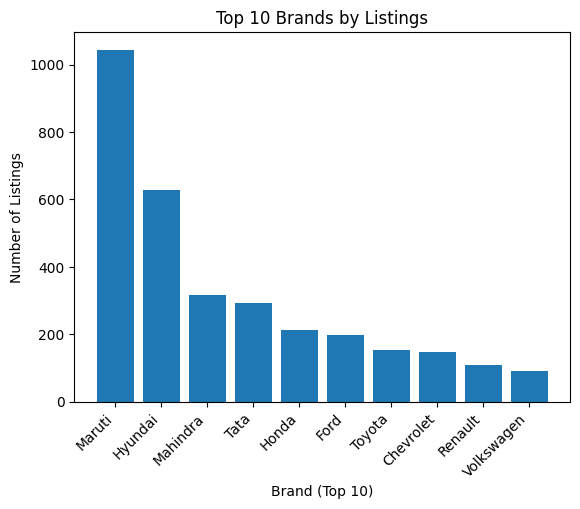

In [19]:
#4 Bar chart: Top 10 brands by listing count
brand_counts = df_filtered["brand"].value_counts().head(10)
plt.figure()
plt.bar(brand_counts.index.astype(str), brand_counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Brand (Top 10)")
plt.ylabel("Number of Listings")
plt.title("Top 10 Brands by Listings")
plt.show()

In [20]:
print("\nCorrelation matrix:\n",
      df_filtered[["year","car_age","selling_price","km_driven"]].corr())

print("\nMedian selling_price by fuel type:\n",
      df_filtered.groupby("fuel")["selling_price"].median())

print("\nMedian selling_price by transmission:\n",
      df_filtered.groupby("transmission")["selling_price"].median())

brand_price_stats = (
    df_filtered.groupby("brand")
    .agg(
        n=("brand", "size"),
        median_price=("selling_price","median"),
        median_km=("km_driven","median"),
        median_year=("year","median")
    )
    .query("n >= 20")
    .sort_values("median_price", ascending=False)
    .head(10)
)
print("\nTop brands by median price (n >= 20):\n", brand_price_stats)


Correlation matrix:
                    year   car_age  selling_price  km_driven
year           1.000000 -1.000000       0.512249  -0.447615
car_age       -1.000000  1.000000      -0.512249   0.447615
selling_price  0.512249 -0.512249       1.000000  -0.212093
km_driven     -0.447615  0.447615      -0.212093   1.000000

Median selling_price by fuel type:
 fuel
CNG         237499.5
Diesel      470000.0
Electric    310000.0
LPG         180000.0
Petrol      260000.0
Name: selling_price, dtype: float64

Median selling_price by transmission:
 transmission
Automatic    750000.0
Manual       325000.0
Name: selling_price, dtype: float64

Top brands by median price (n >= 20):
               n  median_price  median_km  median_year
brand                                                
Audi         22     1325000.0    61118.5       2013.0
Toyota      153      650000.0    90000.0       2013.0
Mahindra    316      550000.0    70500.0       2014.0
Honda       213      490000.0    50000.0       2015.